In [1]:
import numpy as np
import pandas as pd


import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl



# For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 6}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

# Set style
sns.set(style = "whitegrid",
        palette = "pastel",
        color_codes = True)

import cfrna_methods as toolkit

/Users/sevahn/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

# read in raw data and filter

In [3]:
leong_cts = pd.read_csv("../data/rna_seq_cts/leong_htseq_merged.csv",
                       index_col = (0, 1))

leong_meta = pd.read_csv("../data/rna_seq_cts/leong_metadata.csv",
                        index_col = 0)

tumorPatients = leong_meta[['Stage', 'Grade', 'Tumor Size.1']]

In [4]:
# do the cancer staging in leong_meta
cancer_type = []
for i in leong_meta['Stage']:
    if 'ontrol' in i:
        cancer_type += ['control']
    elif 'T1' in i or 'Ta' in i:
        
        cancer_type += ['NMIBC']
    else:
        print(i)
        cancer_type += ['MIBC']
leong_meta['cancer_type'] = cancer_type

T2
T2 + CIS
T2


In [5]:
leong_logcpm = toolkit.logcpm_normalize(leong_cts)
leong_cpm = toolkit.cpm(leong_cts)

counts table has been logcpm normalized
counts table has been cpm normalized


In [6]:
n_samps = leong_cpm.shape[1]
print(f"there are {n_samps} samples.")
filtered_cpm = toolkit.filter_cpm_aboveKThresh(leong_cpm,
                                               cpm_thresh = 0.75, #~10 counts/ sample
                                               k_thresh = 3 / n_samps)

there are 23 samples.
24.8 % genes in at least 13.0 % samples above  0.75  CPM passed.


In [7]:
filtered_cpmonly = leong_cts.loc[filtered_cpm.index]

In [8]:
good_genes = [i for i in filtered_cpmonly.index.get_level_values(1) if 'ERCC' not in i]

In [9]:
filtered_cpmonly_notail = filtered_cpmonly.loc(axis = 0)[:, good_genes].iloc[:-5, :]
#filtered_cpmonly_notail.to_csv("20231230_leong_htseq_raw.csv")

In [10]:
bladder_sigs = pd.read_csv("../data/rna_seq_cts/bladder_urothelial_sig.csv",
                           index_col = 0)
bladder_genes = bladder_sigs['bladder urothelial cell-gini'].dropna().index.tolist()

# tmm normalize

In [11]:
leong_raw = pd.read_csv("20231230_leong_htseq_raw.csv",
                       index_col = (0, 1))

tmm = pd.read_csv("20231230_leong_cts_CPMFILT_TMM_noMA4.csv",
                 index_col = 0)

In [12]:
leong_cpm = leong_raw.div(tmm['lib.size'] * tmm['norm.factors'], axis = 1) * 10 ** 6

In [13]:
leong_cpm.index = leong_cpm.index.swaplevel()

In [14]:
leong_logcpm = np.log(leong_cpm + 1) 

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [16]:
X = leong_logcpm.values 
res = pca.fit_transform(X.T)

res = pd.DataFrame(res)
res.index = leong_logcpm.columns
res = leong_meta.join(res)

In [17]:
# PCA bladder only and assess separation
intersection = np.intersect1d(leong_logcpm.index.get_level_values(0), 
              bladder_genes)
bladder_only = leong_logcpm.loc(axis = 0)[intersection, :]

bladder_pca = pca.fit_transform(bladder_only.T)
bladder_pca = pd.DataFrame(bladder_pca)
bladder_pca.index = bladder_only.columns
bladder_only = bladder_pca.join(leong_meta)

# QC data

In [18]:
leong_dna = pd.read_csv("../data/leong/intron_exon_ratios.txt",
                       sep = "\t", index_col = 0)

leong_3p = pd.read_csv("../data/leong/deg_3prime_bias_frac_1.txt",
                      sep = "\t", index_col = 0)

leong_ribo = pd.read_csv("../data/leong/ribo_frac.txt",
                        sep = "\t", index_col = 0)

leong_qc = leong_ribo.join([leong_3p, leong_dna])

In [19]:
leong_qc['ceil_dna'] = np.ceil(leong_qc.intron_exon_ratio)

In [20]:
bladder_only = bladder_only.join(leong_qc)
res = res.join(leong_qc)

In [21]:
colors = ["8ecae6","219ebc","023047","ffb703","fb8500"]
colors = [f"#{i}" for i in colors]

pal = {}
for i, val in enumerate(np.unique(res.ceil_dna)):
    pal[val] = colors[i]
    


In [22]:
res['is_cancer'] = ["True" if i != 'control' else "False" for i in res.cancer_type]

In [23]:
for i, val in enumerate(np.unique(res.is_cancer)):
    pal[val] = colors[i + 2]

In [24]:
bladder_only['is_cancer'] =  ["True" if i != 'control' else "False" for i in bladder_only.cancer_type]

Text(0, 0.5, 'PCA2')

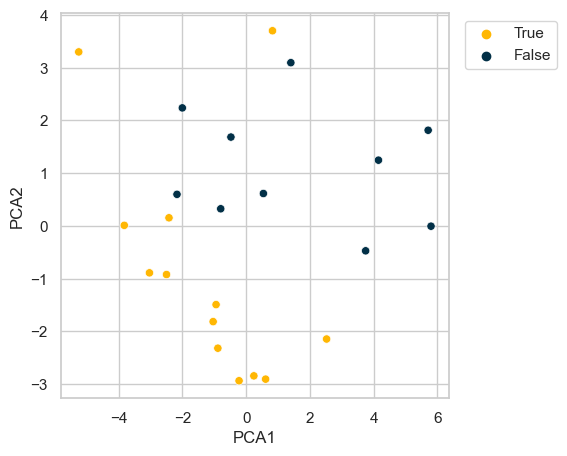

In [25]:
plt.figure(figsize = (5, 5))

sns.scatterplot(data = bladder_only,
                x = 0, y = 1,              
                palette = pal,
                hue = 'is_cancer')

plt.legend(bbox_to_anchor = (1.3, 1))
plt.xlabel("PCA1")
plt.ylabel("PCA2")

#save_figure_pdf(plt, '../figures/20231230_pca_leongBladder_isCancer.pdf')

Text(0, 0.5, 'PCA2')

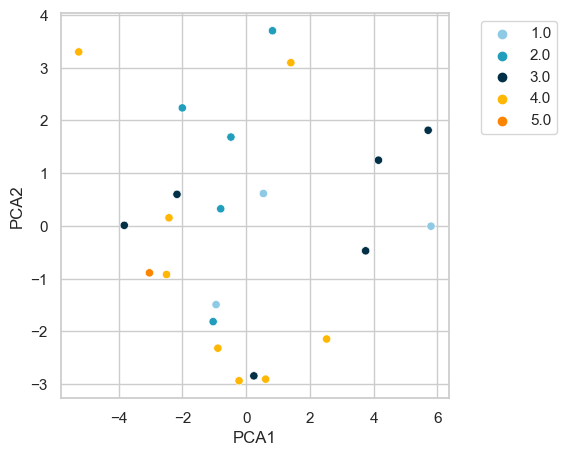

In [26]:
plt.figure(figsize = (5, 5))

sns.scatterplot(data = bladder_only,
                x = 0, y = 1,
                hue = 'ceil_dna',
               palette = pal)

plt.legend(bbox_to_anchor = (1.3, 1))
plt.xlabel("PCA1")
plt.ylabel("PCA2")

#save_figure_pdf(plt, '../figures/20231230_pca_leongBladder_dnaContam.pdf')

/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


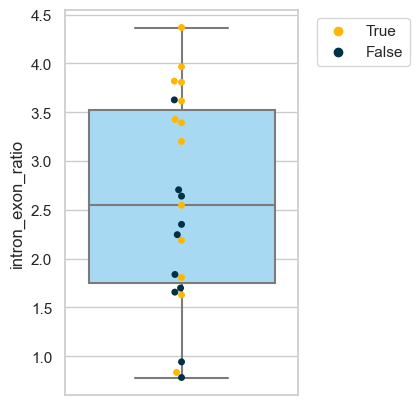

In [27]:
plt.figure(figsize = (3, 5))

sns.boxplot(data = res,
            color = '#9BDDFF',
           y = 'intron_exon_ratio')

sns.swarmplot(data = res,
           y = 'intron_exon_ratio',
             hue = 'is_cancer',
             palette = pal)

plt.legend(bbox_to_anchor = (1.05, 1))

#save_figure_pdf(plt, "../figures/20240101_intronexonratio_leong.pdf")

# sequencing depth

In [28]:
leong_depth = pd.read_csv("../data/leong/leong_depth.txt",
           sep = "\t")

In [29]:
leong_depths = toolkit.extract_star_depth(leong_depth)

In [30]:
leong_depths = leong_depths.loc[leong_depths.index != 'MA4']

In [31]:
np.median(leong_depths.values.T.tolist()[0])

33312839.0

# now perform signature scoring

In [32]:
bladder_sig = leong_logcpm.loc(axis = 0)[intersection, :].sum() / len(intersection)

In [33]:
bladder_sig = pd.DataFrame(bladder_sig, columns = ['sigscore'])

In [34]:
bladder_sig['log(sigscore)'] = np.log10(bladder_sig.sigscore)

In [35]:
res = res.join(bladder_sig)

In [36]:
res['is_cancer'] = [True if i != 'control' else False for i in res.cancer_type]

/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 22.249999999999993, '')

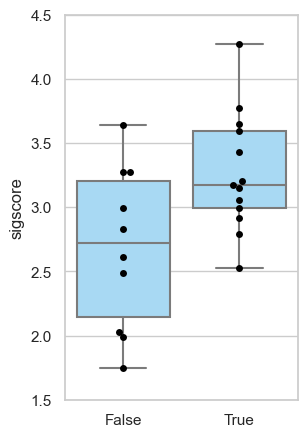

In [37]:
plt.figure(figsize = (3, 5))
sns.boxplot(data = res,
           x = 'is_cancer',
           y = 'sigscore',
            color = '#9BDDFF',
            fliersize = 0,
           order = [False, True])

sns.swarmplot(data = res,
           x = 'is_cancer',
           y = 'sigscore',
           color = "0",
           order = [False, True])
plt.ylim((1.5, 4.5))
plt.xlabel("")
#save_figure_pdf(plt, '../figures/manu_figs/20231230_bladdersig.pdf')

In [38]:
from scipy.stats import mannwhitneyu

In [39]:
ctrl = res[res.is_cancer == False]['sigscore'].values.tolist()
cancer = res[res.is_cancer == True]['sigscore'].values.tolist()

In [40]:
mannwhitneyu(ctrl, cancer, alternative = 'less')

MannwhitneyuResult(statistic=32.0, pvalue=0.021922770830088183)

In [41]:
np.random.seed(10)


pvals = []
difference = []
uList = []

numTrials = 10000

for i in range(numTrials):
    newLabels = np.random.permutation(res["is_cancer"])

    res['shuffled'] = newLabels


    cancer = res[res['shuffled'] == True]['log(sigscore)'].values.tolist()
    ctrl = res[res['shuffled'] == False]["log(sigscore)"].values.tolist()

    
    #u_permute, p_permute = mannwhitneyu(ckd, ctrl, alternative = "two-sided")
    u_permute, p_permute = mannwhitneyu(ctrl, cancer, alternative = "less")


    uList += [u_permute]
    pvals += [p_permute]

/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'p value')

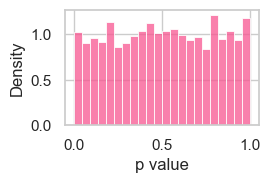

In [42]:
sns.histplot(pvals, color = "#f75590", stat = "density")
plt.xlabel("p value")
#save_figure_pdf(plt, "ptSig_pValDistribPermutation_epoOnly_09222021.pdf")

/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


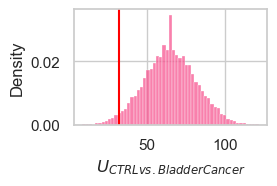

In [43]:
sns.histplot(uList, color = "#f75590", stat = "density")
plt.xlabel(r'$U_{CTRL vs. Bladder Cancer}$')
plt.axvline(32, 0, 2, color = "red")

In [44]:
greater = []
for i in uList:
    if i <= 32 : greater += [i]

In [45]:
len(greater) / numTrials

0.0238